In [ ]:
import xarray as xr
import numpy as np
import zarr
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, time, glob, re
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE

from herbie import Herbie

# set the directory to current directory
root_dir = '/data/harish'
os.chdir(root_dir)

# Extract lat lon boundaries of New York start encompassing MesoNET 

# Start dask cluster

In [2]:
import dask
import dask.distributed as dd
import dask.array as da
# Create a Dask cluster
print("Starting parallel computing...")
cluster = dd.LocalCluster(n_workers=8, dashboard_address=':22722')

# Connect to the cluster
client = dd.Client(cluster)
client

Starting parallel computing...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:22722/status,
Dashboard: http://127.0.0.1:22722/status,Workers: 8
Total threads: 128,Total memory: 503.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43073,Workers: 8
Dashboard: http://127.0.0.1:22722/status,Total threads: 128
Started: Just now,Total memory: 503.49 GiB
Comm: tcp://127.0.0.1:41683,Total threads: 16
Dashboard: http://127.0.0.1:46485/status,Memory: 62.94 GiB
Nanny: tcp://127.0.0.1:44067,


# Check RTMA variables

In [2]:
H = Herbie(
    "2024-01-01 00:00",
    model="rtma",
    product="anl",
    fxx=0,
)
H.inventory()

✅ Found ┊ model=rtma ┊ product=anl ┊ 2024-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
0,1,0,7490117.0,0-7490117,2024-01-01,2024-01-01,HGT,surface,anl,:HGT:surface:anl
1,2,7490118,14980235.0,7490118-14980235,2024-01-01,2024-01-01,PRES,surface,anl,:PRES:surface:anl
2,3,14980236,21065992.0,14980236-21065992,2024-01-01,2024-01-01,TMP,2 m above ground,anl,:TMP:2 m above ground:anl
3,4,21065993,27619869.0,21065993-27619869,2024-01-01,2024-01-01,DPT,2 m above ground,anl,:DPT:2 m above ground:anl
4,5,27619870,33237505.0,27619870-33237505,2024-01-01,2024-01-01,UGRD,10 m above ground,anl,:UGRD:10 m above ground:anl
5,6,33237506,38855141.0,33237506-38855141,2024-01-01,2024-01-01,VGRD,10 m above ground,anl,:VGRD:10 m above ground:anl
6,7,38855142,45877139.0,38855142-45877139,2024-01-01,2024-01-01,SPFH,2 m above ground,anl,:SPFH:2 m above ground:anl
7,8,45877140,51494775.0,45877140-51494775,2024-01-01,2024-01-01,WDIR,10 m above ground,anl,:WDIR:10 m above ground:anl
8,9,51494776,56644290.0,51494776-56644290,2024-01-01,2024-01-01,WIND,10 m above ground,anl,:WIND:10 m above ground:anl
9,10,56644291,62261926.0,56644291-62261926,2024-01-01,2024-01-01,GUST,10 m above ground,anl,:GUST:10 m above ground:anl


In [3]:
H.PRODUCTS

{'anl': 'Analysis',
 'err': 'Analysis Forecast Error',
 'ges': 'Forecasts',
 'pcp': 'Precipitation Field'}

# Download only subset of variables

In [ ]:
from herbie import Herbie

variable = 'HGT'
level = 'surface'
year = '2023'
month = '03'
day = '01'
hour = '02'

download_path = "/data/harish"

H = Herbie(
    f"{year}-{month}-{day}T{hour}:00:00",
    model="rtma",
    product="anl",
    save_dir = download_path,
)

H.download(f"{variable}:{level}",verbose=True)

✅ Found ┊ model=rtma ┊ product=anl ┊ 2023-Mar-01 02:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [13]:
download_path = "/data/harish"
H = Herbie(
    "2023-02-01 02:00",
    model="rtma",
    product="anl",
    save_dir = download_path,
)
filepath = H.download(r"HGT:surface",verbose=True)

# This way, the file is downloaded to the specified path and the file path is returned
filepath = str(filepath)
ds = xr.open_dataset(filepath,engine="cfgrib",backend_kwargs={'indexpath': ''})
ds

✅ Found ┊ model=rtma ┊ product=anl ┊ 2023-Feb-01 02:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
🌉 Already have local copy --> /data/harish/rtma/20230201/subset_48ef795e__rtma2p5.t02z.2dvaranl_ndfd.grb2_wexp


<xarray.Dataset>
Dimensions:     (y: 1597, x: 2345)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    orog        (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-11-02T22:15 GRIB to CDM+CF via cfgrib-0.9.1...

In [17]:
ds.surface.values

array(0.)

# Reading downloaded RTMA subset grib files

In [4]:
ds = xr.open_dataset('/home/harish/Ongoing_Research/gUstNET/subset_0def4a4d__rtma2p5.t05z.2dvaranl_ndfd.grb2_wexp',
                     engine="cfgrib",backend_kwargs={'indexpath': ''})
ds

<xarray.Dataset>
Dimensions:            (y: 1597, x: 2345)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    i10fg              (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-04-11T17:29 GRIB to CDM+CF via cfgrib-0.9.1...

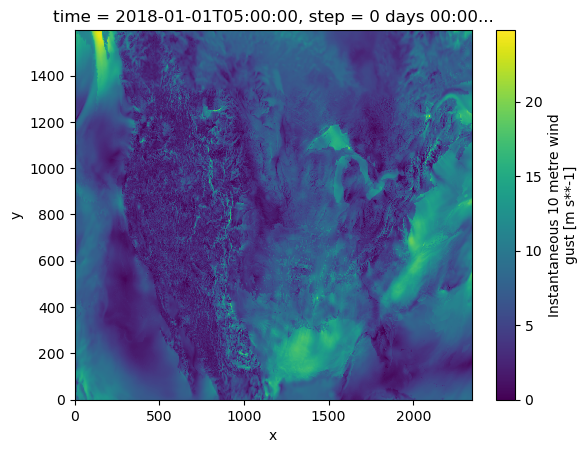

In [5]:
ds.i10fg.plot()

## Extract spatial subset 

In [6]:
# goal is to get a perfect size that we can use in machine learning training aswell
# 256*256 cannot cover the entire 
geogrid = xr.open_dataset('geo_em.d03.nc')
XLAT_M = geogrid['XLAT_M'].values[0]
XLONG_M = geogrid['XLONG_M'].values[0]

target_grid = {'min_lat': XLAT_M.min(), 'min_lon': XLONG_M.min(),'max_lat':XLAT_M.max(),'max_lon':XLONG_M.max()}
#target_grid = {'min_lat': 40, 'min_lon': -79.8+360,'max_lat':46,'max_lon':-71+360}
print(target_grid)

{'min_lat': 38.59337, 'min_lon': -83.39511, 'max_lat': 46.56383, 'max_lon': -68.39929}


In [7]:
def longitude_convert_0_to_360(lon):
    '''
    returns longitude in the range of 0 to 360
    '''
    return np.where(lon >= 0, lon, lon + 360)

def regional_extraction(ds,target_grid):
    '''
    ds: xarray DataArray
    target_grid: dict, keys are 'min_lat','max_lat','min_lon','max_lon'
    returns data: xarray DataArray of the region
    Extracts CERRA subsets based on the target grid
    '''
    min_lat = target_grid['min_lat']
    max_lat = target_grid['max_lat']
    min_lon = longitude_convert_0_to_360(target_grid['min_lon']-1)
    max_lon = longitude_convert_0_to_360(target_grid['max_lon']+1)
    distance_squared = (ds.latitude - min_lat)**2 + (ds.longitude - min_lon)**2
    indices_ll = np.unravel_index(np.nanargmin(distance_squared), distance_squared.shape)
    distance_squared = (ds.latitude - max_lat)**2 + (ds.longitude - max_lon)**2
    indices_uu = np.unravel_index(np.nanargmin(distance_squared), distance_squared.shape)
    print(indices_ll,indices_uu)
    data = ds.sel(y=slice(indices_ll[0],indices_uu[0]),x = slice(indices_ll[1],indices_uu[1]))
    return data

In [8]:
subset_ds = regional_extraction(ds,target_grid).i10fg

(720, 1661) (1163, 2180)


In [9]:
def map_plotter(fig,gs,data,x,y,levels,cmap,title,shrink,colorbar,cbar_label,orientation,extent=None,rectangles=None,sample_points=None,fontsize=None,pad=None):    
    ax = fig.add_subplot(gs,projection=ccrs.PlateCarree())
    ax.coastlines()
    
    contour = data.plot.contourf(
        x=x,y=y,add_colorbar=False,cmap = cmap,extend='both',
        #cbar_kwargs = {'orientation':orientation, 'shrink':shrink, 'aspect':40, 'label':cbar_label,'fontsize':fontsize},
        ax=ax)
    
    # Add colorbar with font size
    if colorbar:
        cbar = fig.colorbar(contour, orientation=orientation, shrink=shrink, aspect=40, label=cbar_label,pad=pad)
        cbar.ax.tick_params(labelsize=fontsize)
        if orientation == 'horizontal':
            cbar.ax.set_xlabel(cbar_label, fontsize=fontsize)
            cbar.ax.xaxis.set_label_position('top')
        else:
            cbar.ax.set_ylabel(cbar_label, fontsize=fontsize)
            cbar.ax.yaxis.set_label_position('left')
            
    
    if extent:
        # Set the extent (for example, bounding box for Europe)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Set x and y ticks font size
    gl.xlabel_style = {'size': fontsize}
    gl.ylabel_style = {'size': fontsize}
    
    # set title
    ax.set_title(title,fontsize=fontsize)
    
    # Add land feature with grey color
    land_feature = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m', edgecolor='face', facecolor='lightgrey'
    )
    #ax.add_feature(land_feature)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, edgecolor='black')
    
    # Add country borders
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, edgecolor='black')
    
    # Add U.S. state boundaries
    ax.add_feature(cfeature.STATES, linestyle='-', linewidth=0.5, edgecolor='black')  # U.S. state boundaries
    
    if sample_points:
        for label, (lat, lon) in sample_points.items():
            ax.text(lon, lat - 0.05, label, color='black', fontsize=fontsize, ha='center', va='center')
            ax.plot(lon, lat, '.', markersize=8,color='black')
    
    if rectangles:
        target_grid = {'min_lat': 41.25, 'min_lon': -9.35,'max_lat':41.8,'max_lon':-8.65}
        # Draw a rectangular boxes
        min_lon = target_grid['min_lon']
        min_lat = target_grid['min_lat']
        max_lon = target_grid['max_lon']
        max_lat = target_grid['max_lat']
        rect = matplotlib.patches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                                        linestyle='--', linewidth=1, edgecolor='red', facecolor='none',zorder=10)
        ax.add_patch(rect)
        
    return ax

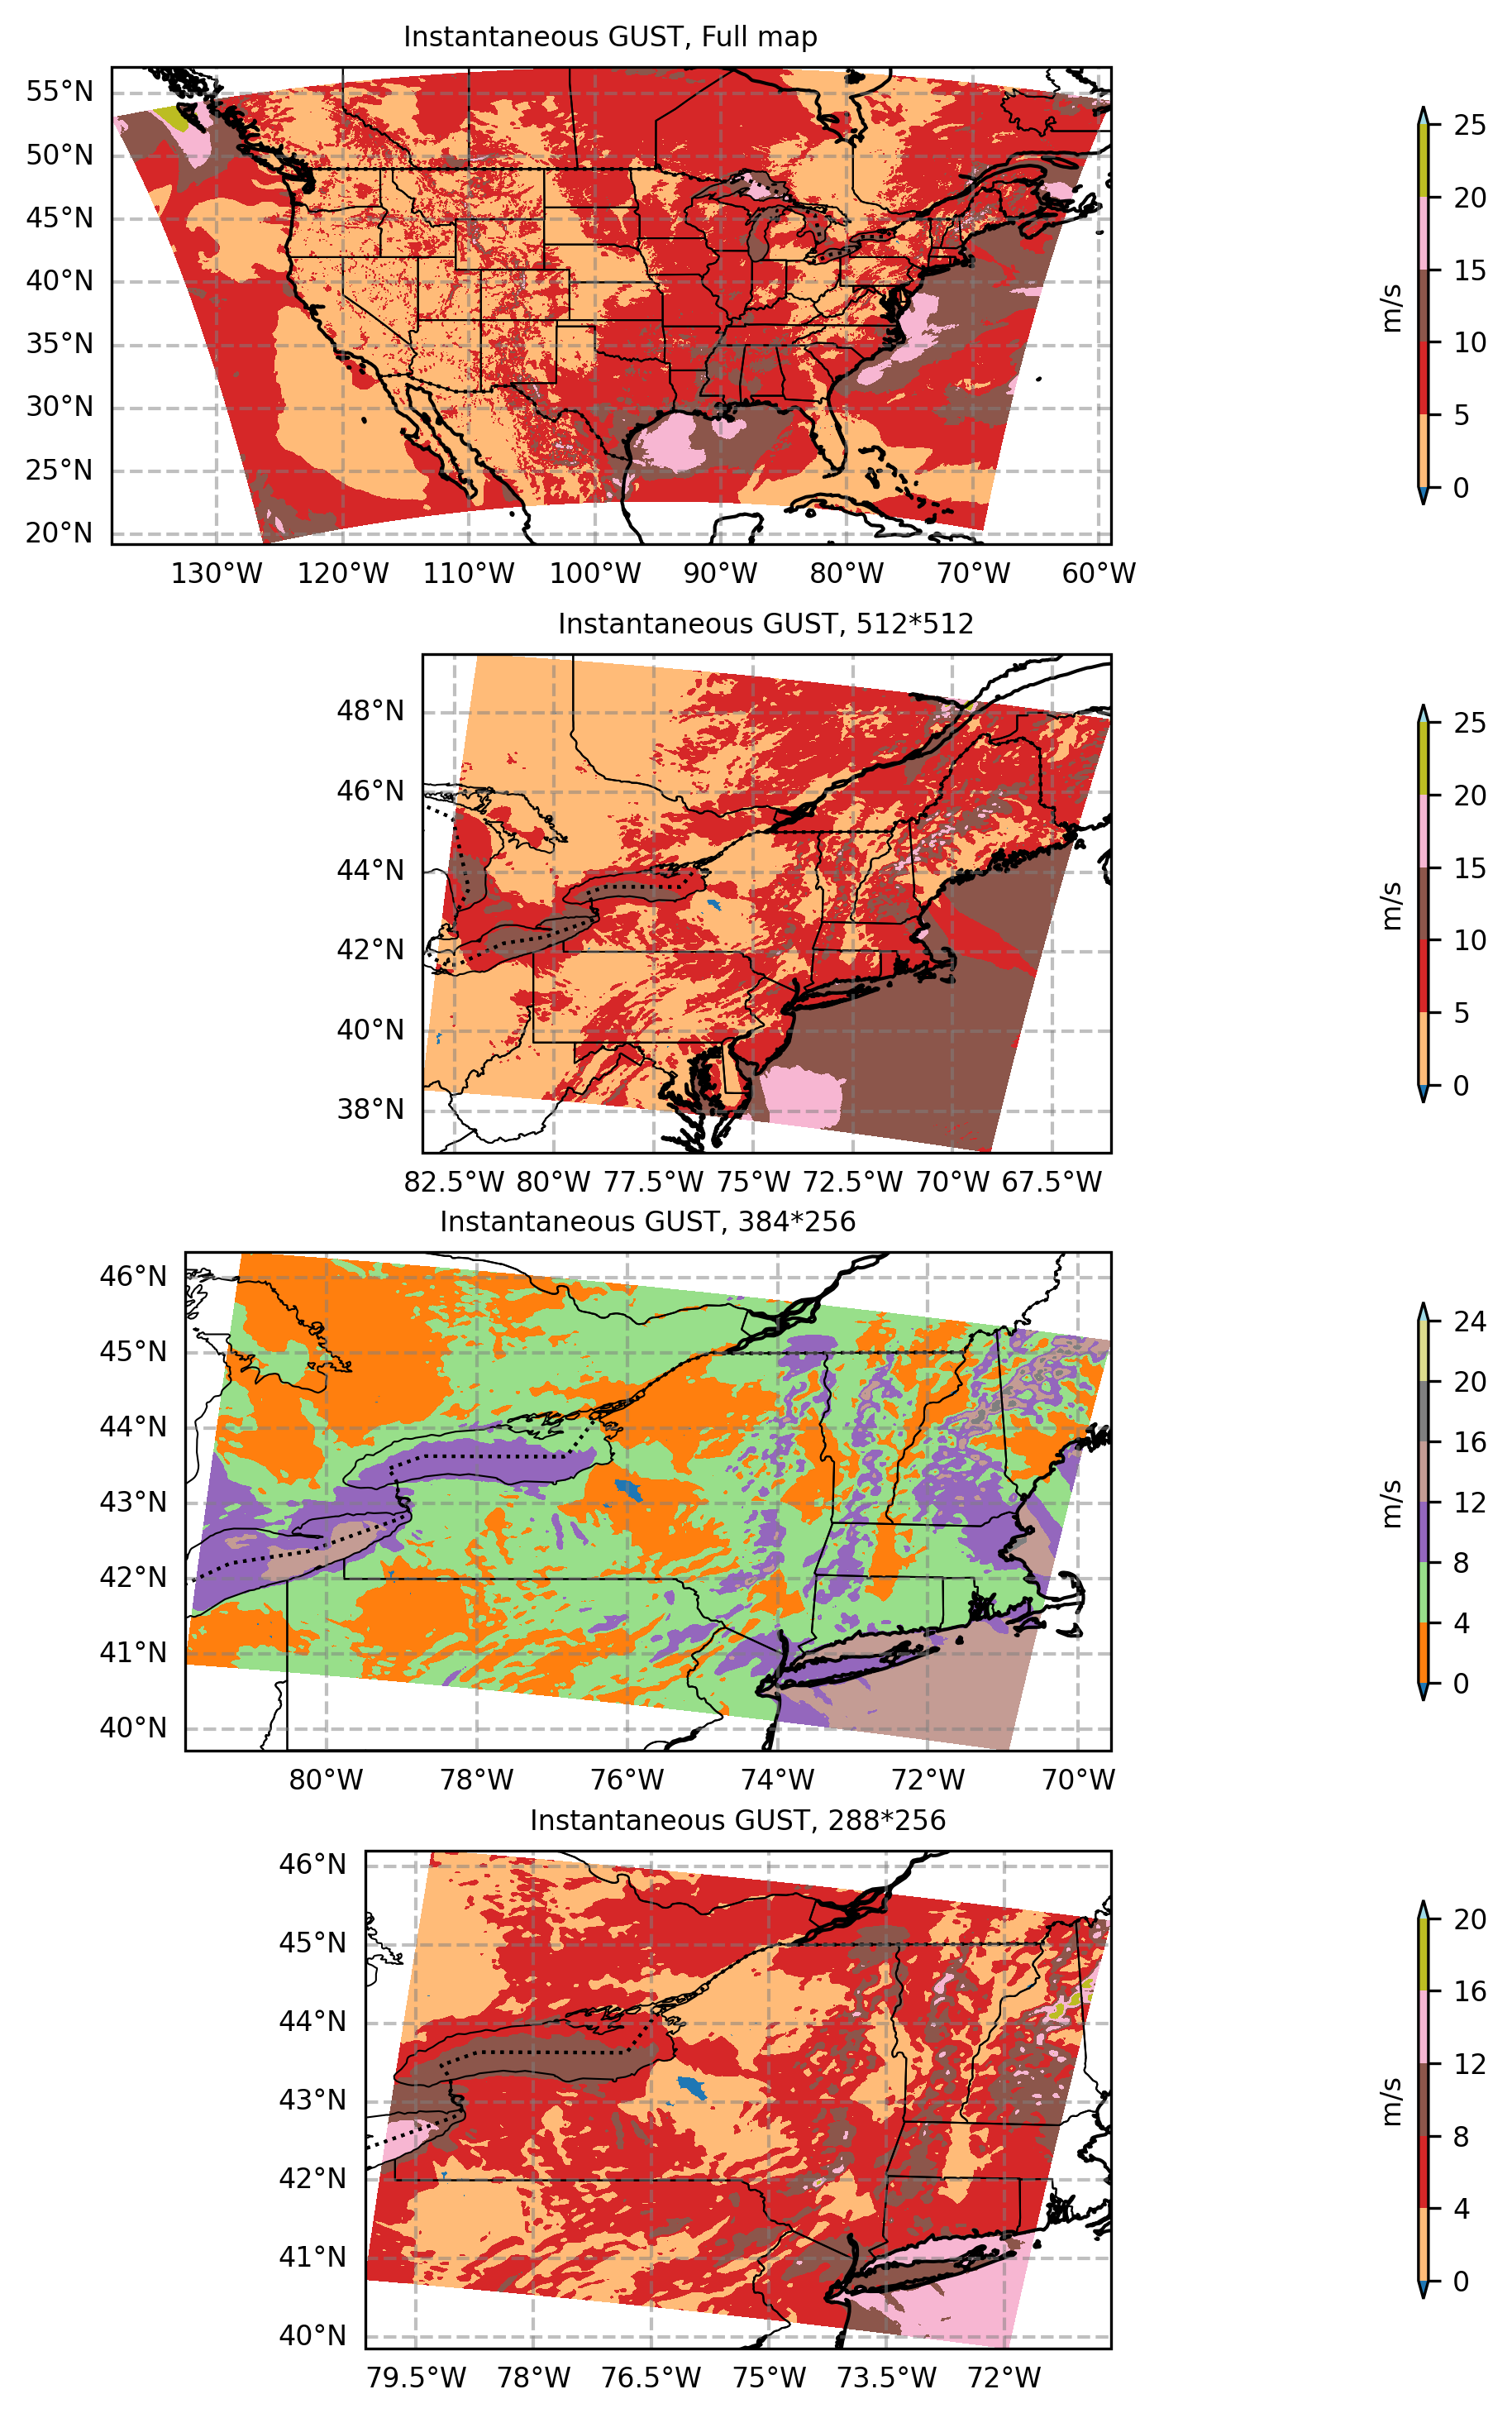

In [18]:
fig = plt.figure(figsize=(8,12), dpi=300)
gs = matplotlib.gridspec.GridSpec(4, 1)

map_plotter(fig,gs[0,0],ds.i10fg,x='longitude',y='latitude',levels=np.arange(0,40.1,5),cmap='tab20',
                title=f'Instantaneous GUST, Full map',shrink=0.8,colorbar=True,cbar_label='m/s',
                orientation='vertical',fontsize=8,pad=0.2)
map_plotter(fig,gs[1,0],ds.i10fg.isel(y=slice(720,720+512),x=slice(1700,1700+512)),x='longitude',y='latitude',levels=np.arange(0,40.1,5),cmap='tab20',
                title=f'Instantaneous GUST, 512*512',shrink=0.8,colorbar=True,cbar_label='m/s',
                orientation='vertical',fontsize=8,pad=0.2)
map_plotter(fig,gs[2,0],ds.i10fg.isel(y=slice(830,830+256),x=slice(1740,1740+384)),x='longitude',y='latitude',levels=np.arange(0,40.1,5),cmap='tab20',
                title=f'Instantaneous GUST, 384*256',shrink=0.8,colorbar=True,cbar_label='m/s',
                orientation='vertical',fontsize=8,pad=0.2)
map_plotter(fig,gs[3,0],ds.i10fg.isel(y=slice(830,830+256),x=slice(1800,1800+288)),x='longitude',y='latitude',levels=np.arange(0,40.1,5),cmap='tab20',
                title=f'Instantaneous GUST, 288*256',shrink=0.8,colorbar=True,cbar_label='m/s',
                orientation='vertical',fontsize=8,pad=0.2)
plt.savefig('gust.png',bbox_inches='tight')

- The reasonal extraction script with latitude and longitude values is good.
- But, through trail and error, we found that the indice values is better.
- Now, the boundaries are
- - isel(y=slice(830,830+256),x=slice(1740,1740+384))

# Reading and extracting subset at every day, and saving into netcdf
- Care should be taken to read the files in order. 
- The key order in the file names is: t00z, t01z, ... , t23z

In [39]:
# read files in sorted order with keywords in the ascending order t00z, t01z, ... , t23z

files = glob.glob(f'{root_dir}/rtma/20180101/*')
def extract_hour(file):
    # Match the pattern 'tXXz' where XX is the hour (e.g., t00z, t01z, etc.)
    match = re.search(r't(\d{2})z', file)
    if match:
        return int(match.group(1))  # Return the hour as an integer
    return 0  # Default in case no match is found (although unlikely here)

# Sort the files by the extracted hour
sorted_files = sorted(files, key=extract_hour)

In [12]:
def preprocess(ds):
    return ds.isel(y=slice(830,830+256),x=slice(1740,1740+384))

In [40]:
ds = xr.open_mfdataset(sorted_files,concat_dim='time',combine='nested', parallel=True, preprocess=preprocess,
                       engine="cfgrib", backend_kwargs={'indexpath': ''})
ds.to_netcdf(f'{root_dir}/intermediate_files/20180101.nc')

# Read the intermediate monthly files and save them into big file

In [2]:
files = sorted(glob.glob(f'{root_dir}/intermediate_files/2019*.nc'))
files

['/data/harish/intermediate_files/20190101.nc',
 '/data/harish/intermediate_files/20190102.nc',
 '/data/harish/intermediate_files/20190103.nc',
 '/data/harish/intermediate_files/20190104.nc',
 '/data/harish/intermediate_files/20190105.nc',
 '/data/harish/intermediate_files/20190106.nc',
 '/data/harish/intermediate_files/20190107.nc',
 '/data/harish/intermediate_files/20190108.nc',
 '/data/harish/intermediate_files/20190109.nc',
 '/data/harish/intermediate_files/20190110.nc',
 '/data/harish/intermediate_files/20190111.nc',
 '/data/harish/intermediate_files/20190112.nc',
 '/data/harish/intermediate_files/20190113.nc',
 '/data/harish/intermediate_files/20190114.nc',
 '/data/harish/intermediate_files/20190115.nc',
 '/data/harish/intermediate_files/20190116.nc',
 '/data/harish/intermediate_files/20190117.nc',
 '/data/harish/intermediate_files/20190118.nc',
 '/data/harish/intermediate_files/20190119.nc',
 '/data/harish/intermediate_files/20190120.nc',
 '/data/harish/intermediate_files/201901

In [3]:
ds  = xr.open_mfdataset(files,concat_dim='time',combine='nested', parallel=True)
ds

<xarray.Dataset>
Dimensions:            (time: 8758, y: 256, x: 384)
Coordinates:
  * time               (time) datetime64[ns] 2019-01-01 ... 2019-12-31T23:00:00
    step               timedelta64[ns] 00:00:00
    heightAboveGround  float64 10.0
    latitude           (y, x) float64 dask.array<chunksize=(256, 384), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(256, 384), meta=np.ndarray>
    valid_time         (time) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    i10fg              (time, y, x) float32 dask.array<chunksize=(24, 256, 384), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-09-16T16:50 GRIB to CDM+CF via cfgrib-0.9.1...

# Read yearly files and combine them in zarr

In [3]:
chunks = {'time': 1, 'y': 256, 'x': 384}
files = sorted(glob.glob(f'{root_dir}/rtma_i10fg_NYS_subset/*.nc'))
ds  = xr.open_mfdataset(files,concat_dim='time',combine='nested', parallel=True,chunks=chunks)
ds

<xarray.Dataset>
Dimensions:            (time: 52453, y: 256, x: 384)
Coordinates:
  * time               (time) datetime64[ns] 2018-01-01 ... 2023-12-31T23:00:00
    step               timedelta64[ns] 00:00:00
    heightAboveGround  float64 10.0
    latitude           (y, x) float64 dask.array<chunksize=(256, 384), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(256, 384), meta=np.ndarray>
    valid_time         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    i10fg              (time, y, x) float32 dask.array<chunksize=(1, 256, 384), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-09-16T16:46 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
zarr_path = f'{root_dir}/rtma_i10fg_NYS_subset.zarr'
# Write to Zarr
ds.to_zarr(zarr_path, mode='w', consolidated=True)